# ML: Intro to Time Series and Forecasting

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 6)

In [10]:
mobile_sales = pd.read_excel('mobilesales.xlsx')
mobile_sales.head()

,DATE,Sales
0,2001-01-01,6519.0
1,2001-02-01,6654.0
2,2001-03-01,7332.0
3,2001-04-01,7332.0
4,2001-05-01,8240.0


In [11]:
mobile_sales.DATE.describe()

C:\Users\khush\AppData\Local\Temp\ipykernel_13608\20359885.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  mobile_sales.DATE.describe()


count                     217
unique                    217
top       2001-01-01 00:00:00
freq                        1
first     2001-01-01 00:00:00
last      2019-01-01 00:00:00
Name: DATE, dtype: object

In [12]:
18*12 # There's no record missing.

216

In [13]:
# set the timeperiod as index 
mobile_sales.set_index('DATE', inplace=True)

<Axes: xlabel='DATE'>

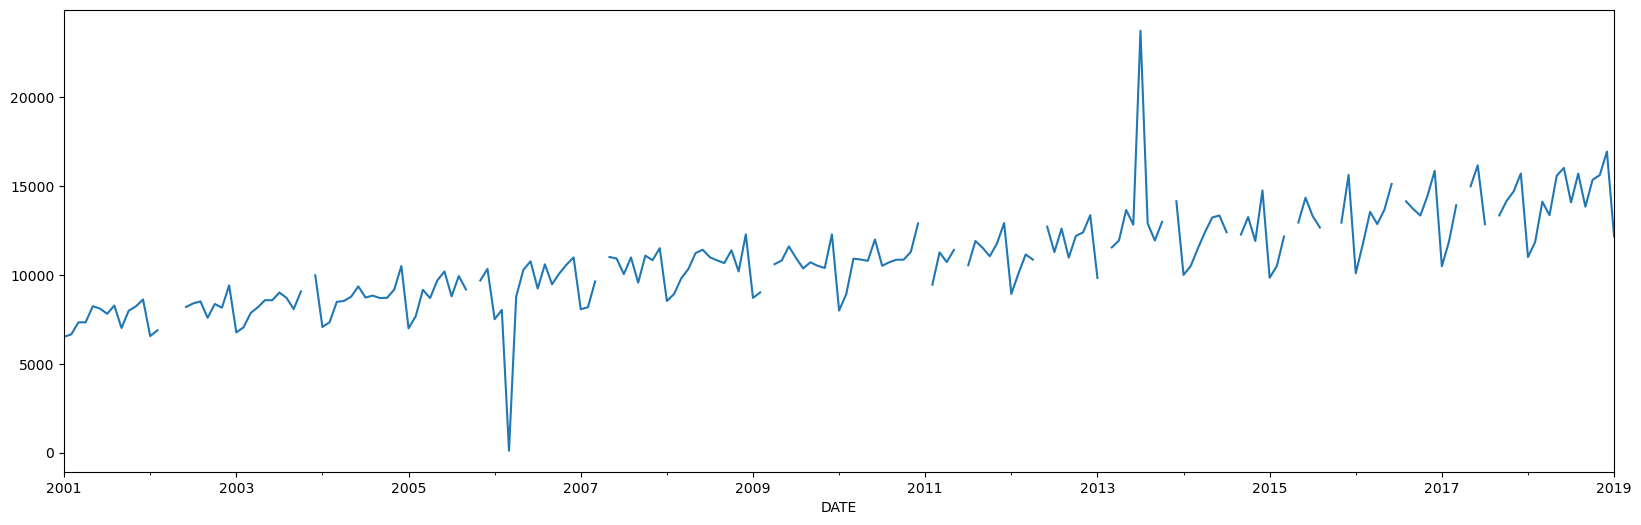

In [14]:
mobile_sales.Sales.plot() # we don't have to explicitly mention X axis as DATE is our index.

- These breaks are missing values
- Two spikes are there. One low and one high. These can be outliers, anomalies. Let's call them abnormalities for now.
- In Time Series, there should not be any discontinuity. 

### Doing Mean Imputation

In [15]:
mn = mobile_sales.Sales.mean()

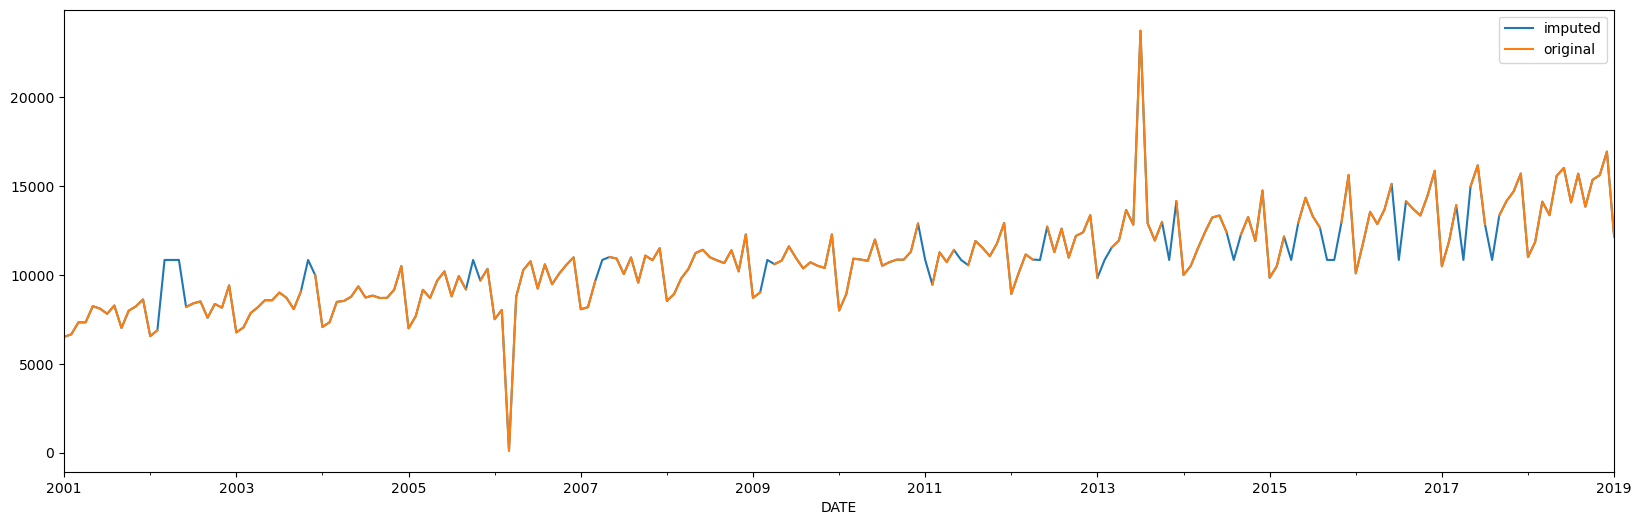

In [16]:
mobile_sales.Sales.fillna(mn).plot(label='imputed')
mobile_sales.Sales.plot(label='original')
plt.legend()

If you see, the blue point looks pretty odd because of the mean imputation.

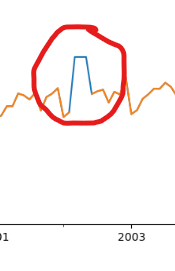

If you see, the peak has two values which have been imputed.

To avoid that, we have something called as interpolate.

### Interpolation

There are two methods for interpolation: 
- Linear: Linear interpolation estimates values between two known data points by assuming that the relationship between the data points is linear. In other words, it assumes that the data forms a straight line between the two points. 
- Pad: When you use 'pad' as the interpolation method, pandas will fill in missing values with the most recent known value that occurs before the missing data point. This method is also commonly referred to as forward fill.

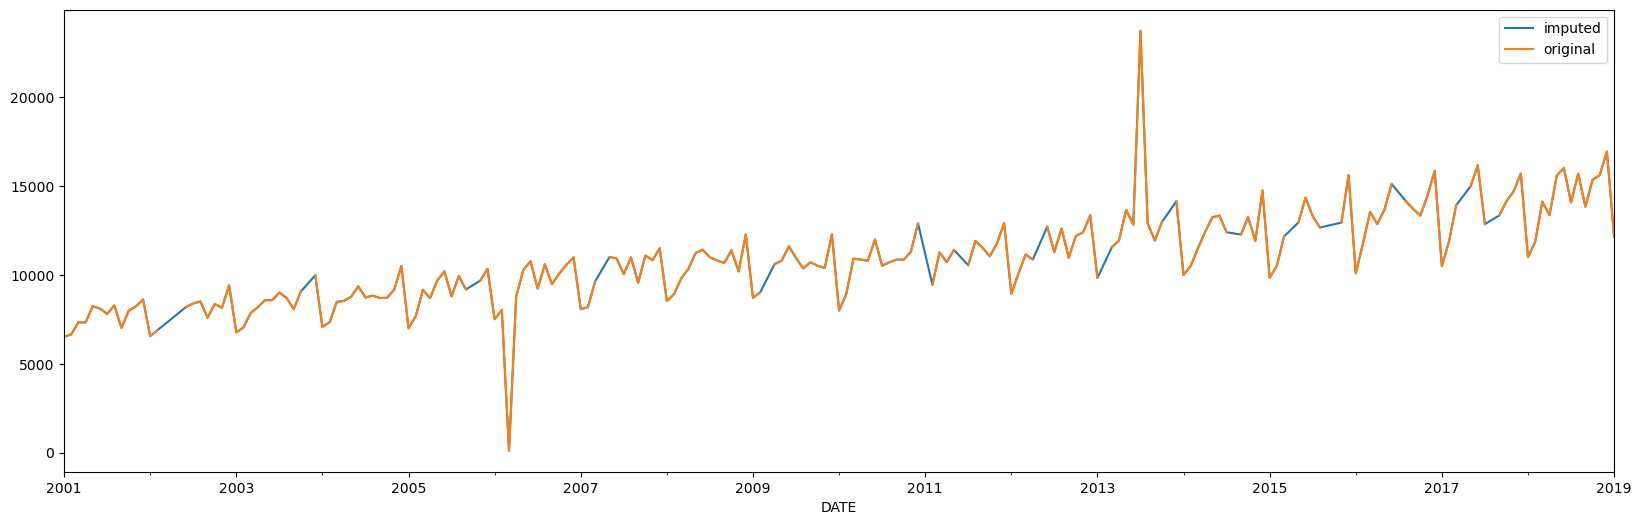

In [17]:
mobile_sales.Sales.interpolate(method='linear').plot(label='imputed')
mobile_sales.Sales.plot(label='original')
plt.legend()

See how the two values have been replaced smoothly.

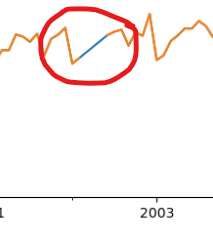

**Pad:** When you use 'pad' as the interpolation method, pandas will fill in missing values with the most recent known value that occurs before the missing data point. This method is also commonly referred to as forward fill.

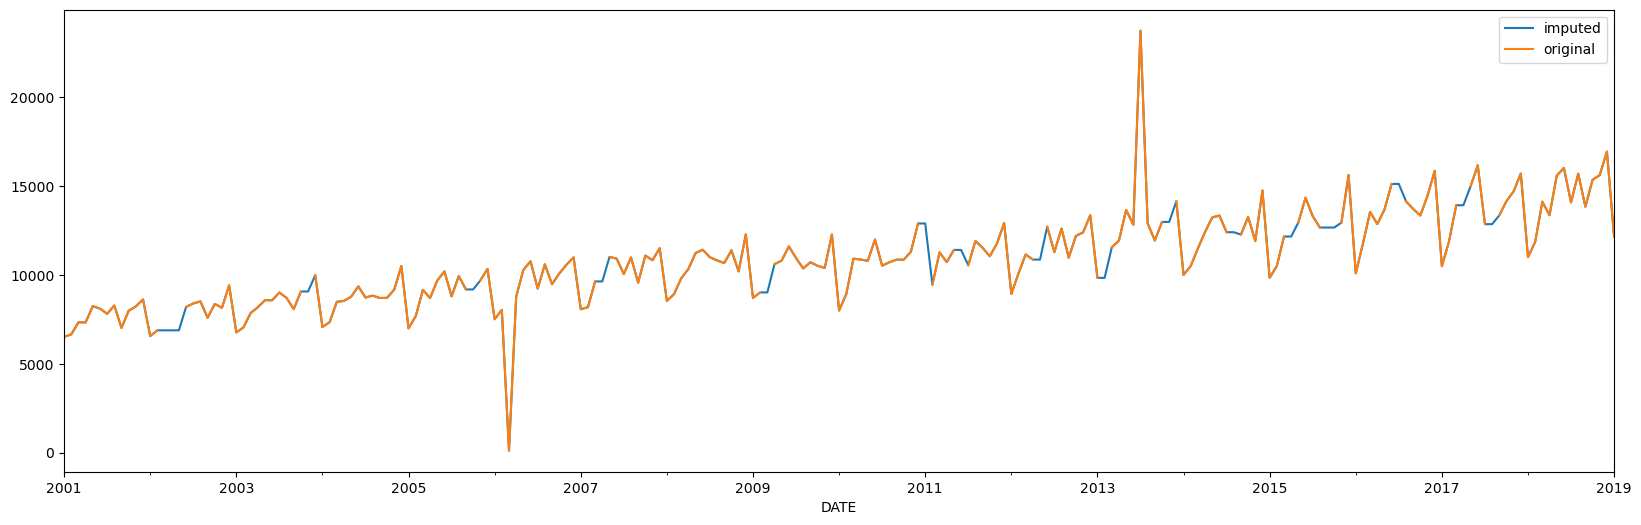

In [18]:
mobile_sales.Sales.interpolate(method='pad').plot(label='imputed')
mobile_sales.Sales.plot(label='original')
plt.legend()

### Outlier Treatement

##### Capping

[]

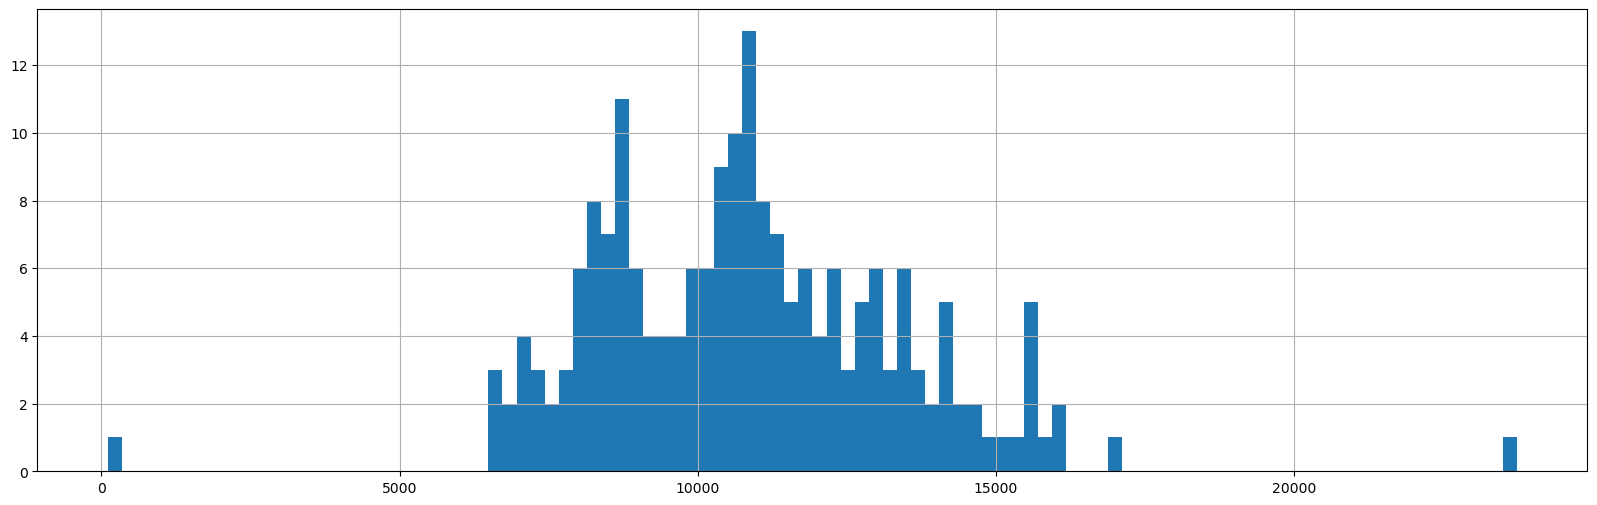

In [19]:
mobile_sales.Sales.hist(bins=100).plot()

Majority of time series is starting from somewhere 6000 and going up to 16000 approx. Can we say we have one low outlier and one extreme outlier?

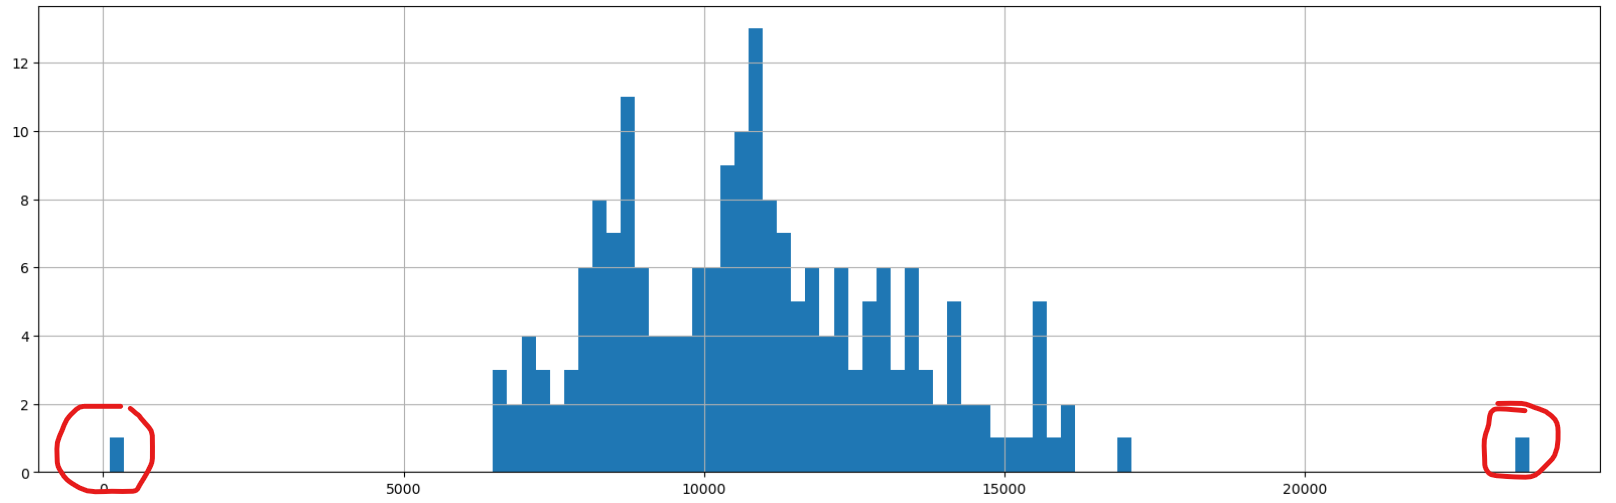

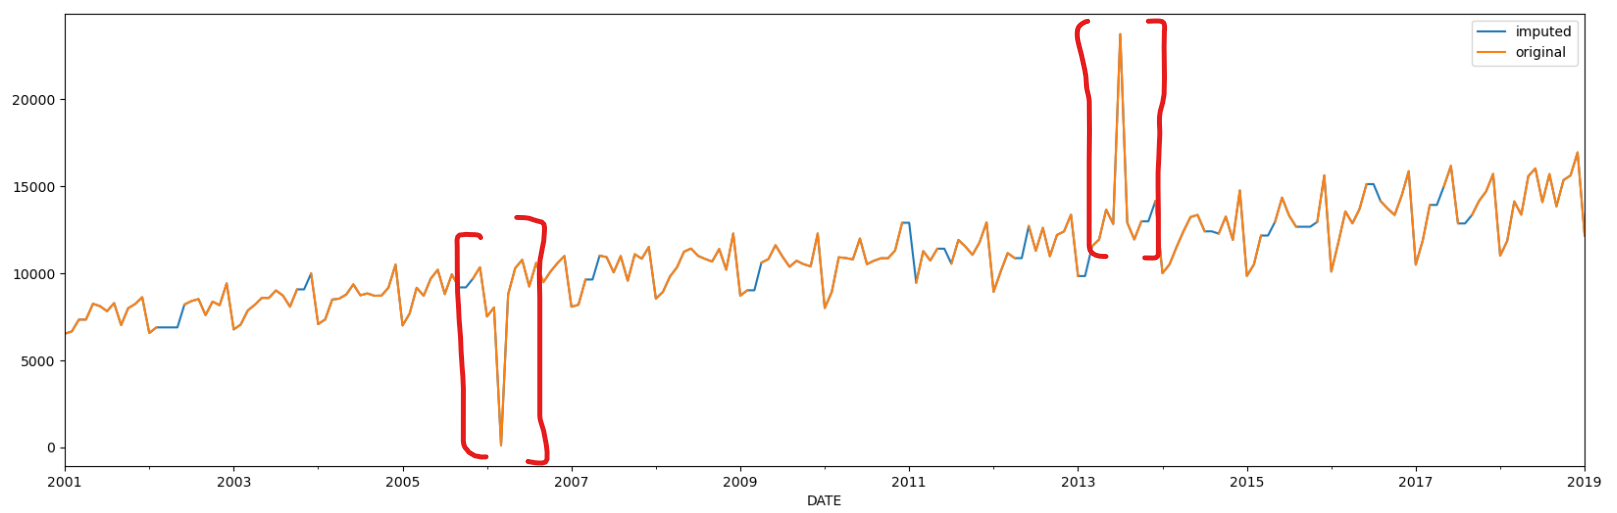

In [20]:
# clipping
mobile_sales.Sales = mobile_sales.Sales.clip(upper=mobile_sales.Sales.quantile(0.99), lower=mobile_sales.Sales.quantile(0.01))

# The result is that values in the 'Sales' column that are below the 1st percentile are replaced with the 1st percentile value, 
# and values above the 99th percentile are replaced with the 99th percentile value

<Axes: xlabel='DATE'>

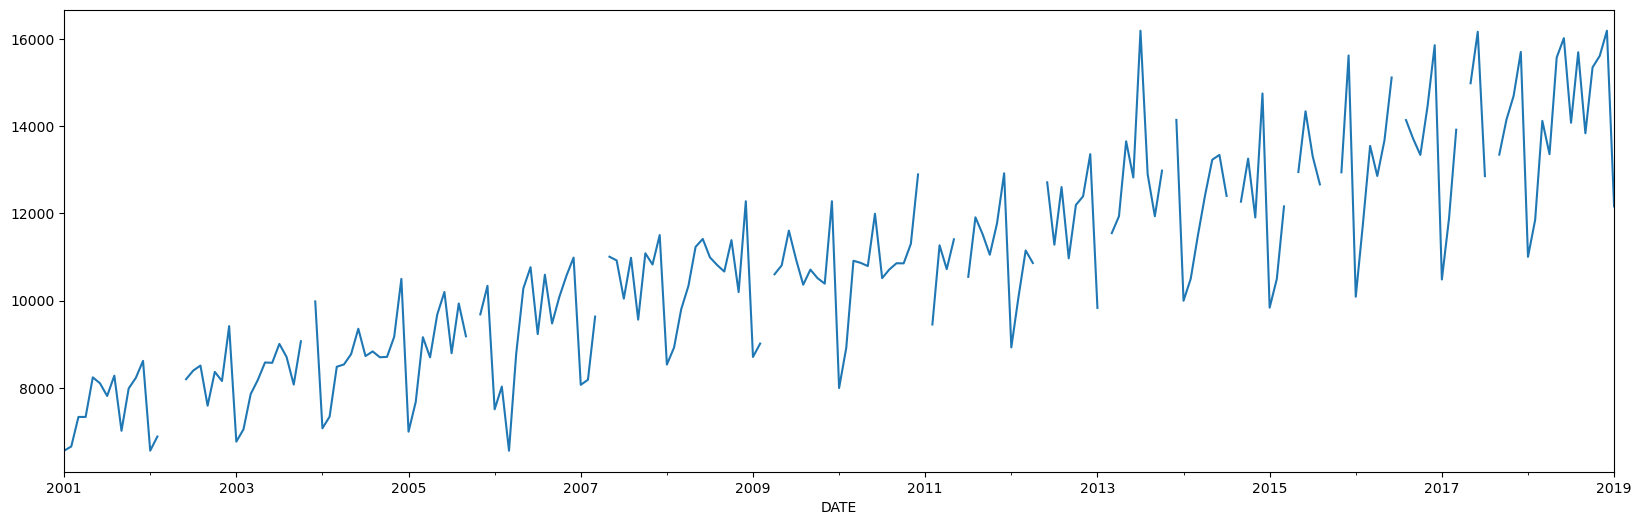

In [21]:
mobile_sales.Sales.plot(label='Clipped')

<Axes: xlabel='DATE'>

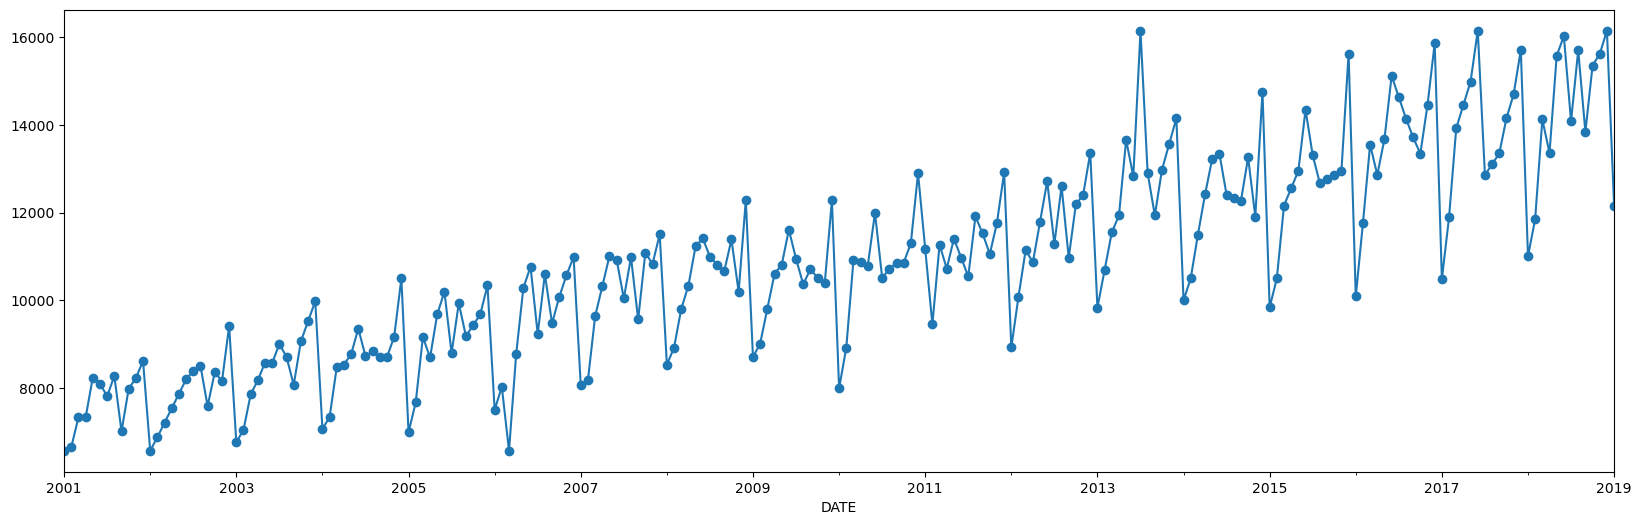

In [22]:
# Putting all steps together
mobile_sales = pd.read_excel('mobilesales.xlsx')
mobile_sales.set_index('DATE', inplace=True)
mobile_sales.Sales = mobile_sales.Sales.interpolate()
mobile_sales.Sales = mobile_sales.Sales.clip(upper=mobile_sales.Sales.quantile(0.99), lower=mobile_sales.Sales.quantile(0.01))
mobile_sales.Sales.plot(style='-o')

In [37]:
mobile_sales.isnull().sum()

Sales    0
dtype: int64

### Moving Averages (AKA rolling)

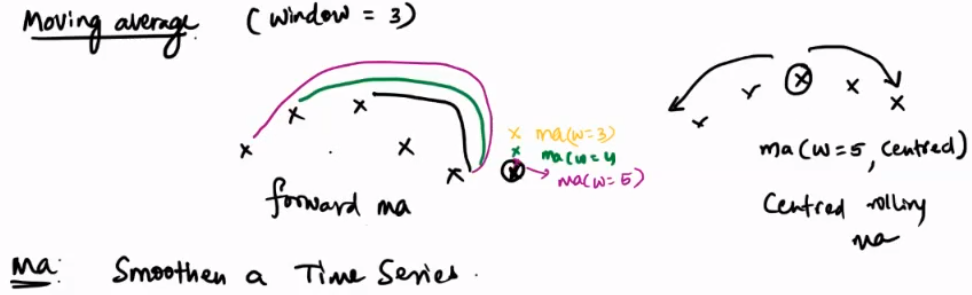

(center = True) means centered rolling ma<br>
(center = False) means forward ma

<Axes: xlabel='DATE'>

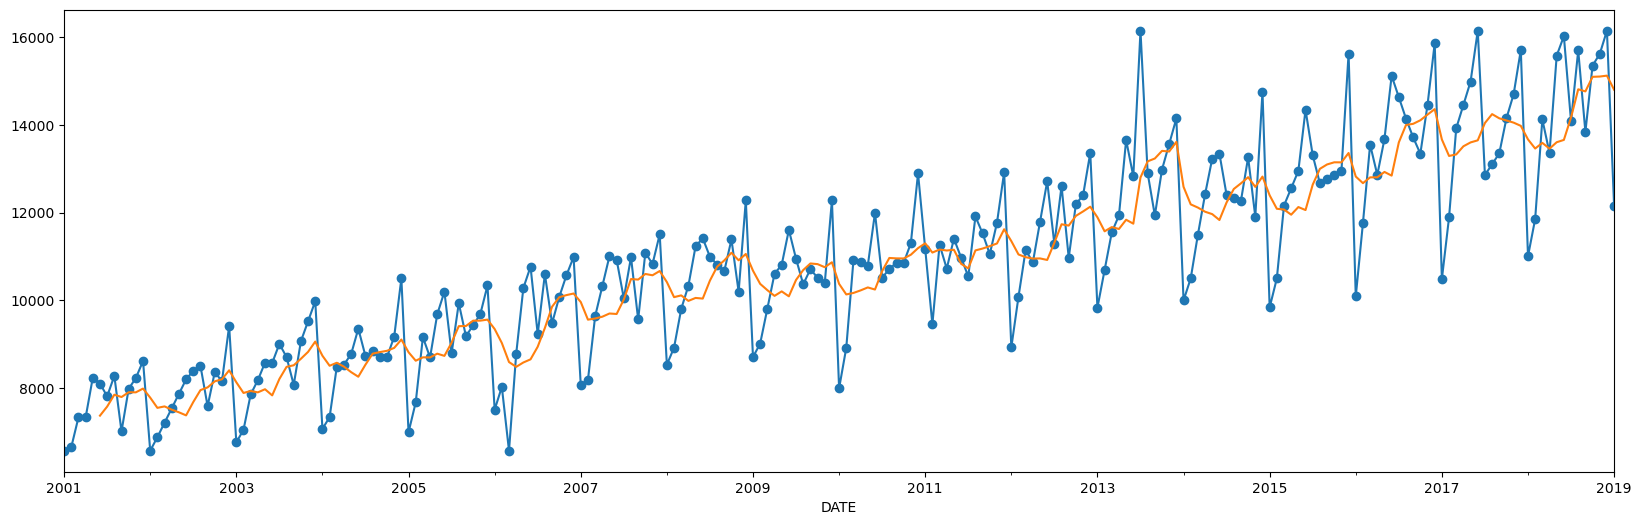

In [23]:
mobile_sales.Sales.plot(style='-o')
mobile_sales.Sales.rolling(6, center=False).mean().plot() 

# for each data point, the mean of the current point and the previous five points (total of six points) will be calculated.

The orange line is the moving avg. It trimmed a lot of fluctuation in the time series and showing what is the pattern.<br>
For a long term invester, a stock has many fluctuations and is confusing. But, he's not worried about 2-3 months. <br>
For that, moving avg reveals that pattern.

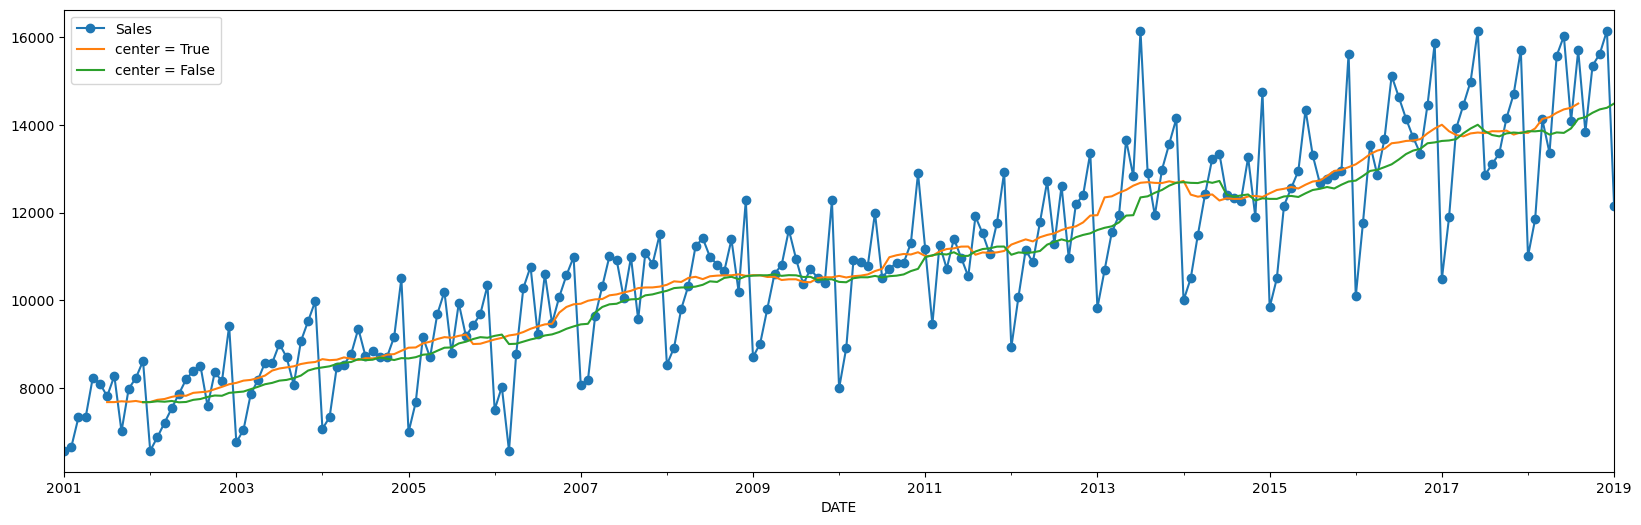

In [24]:
mobile_sales.Sales.plot(style='-o')
mobile_sales.Sales.rolling(12, center=True).mean().plot(label='center = True')
mobile_sales.Sales.rolling(12, center=False).mean().plot(label = 'center = False')
plt.legend()

### Additive Decomposition

In [25]:
import statsmodels.api as sm

model = sm.tsa.seasonal_decompose(mobile_sales.Sales, model='additive')   # tsa = time series analysis

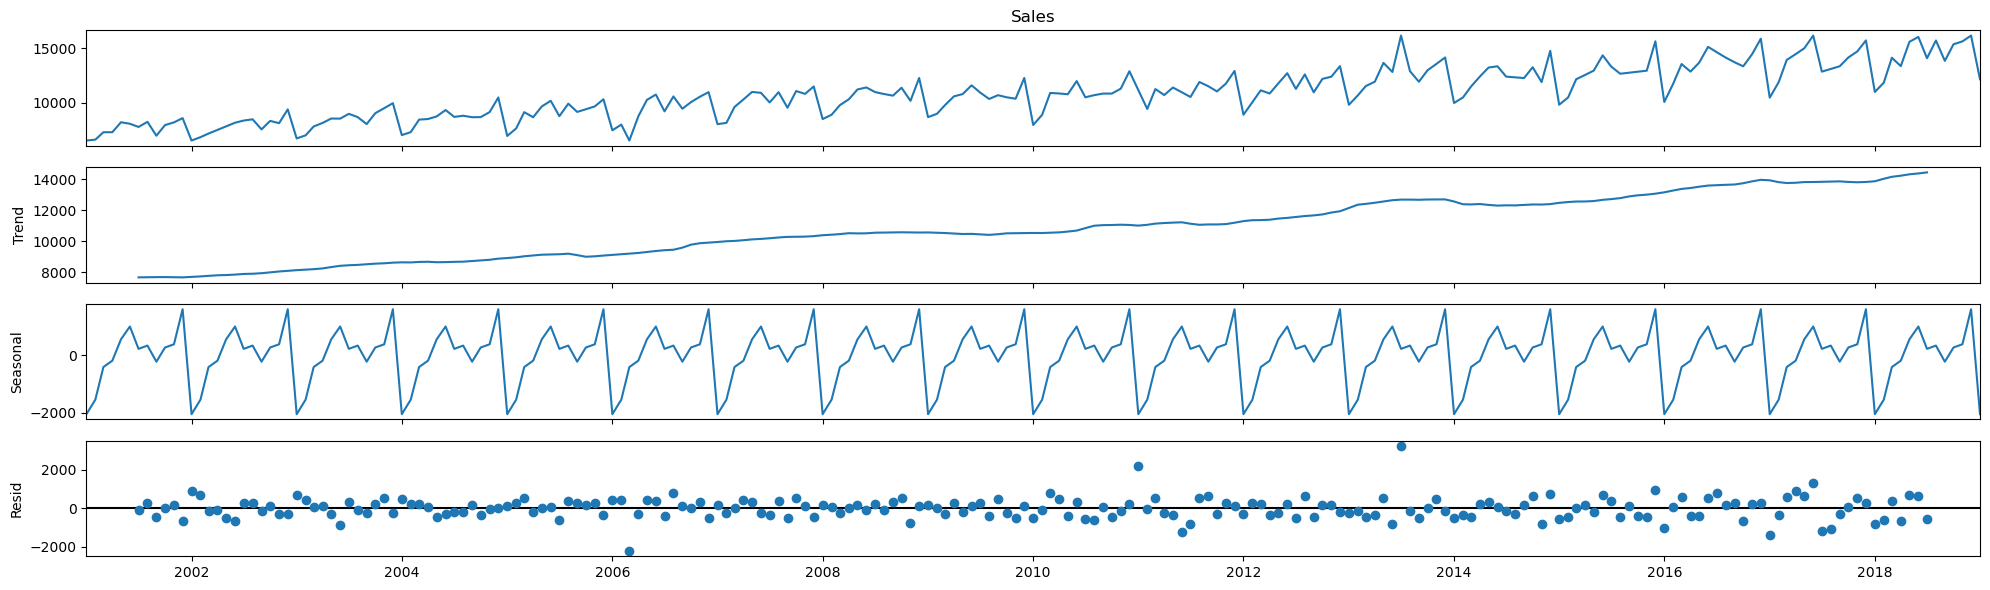

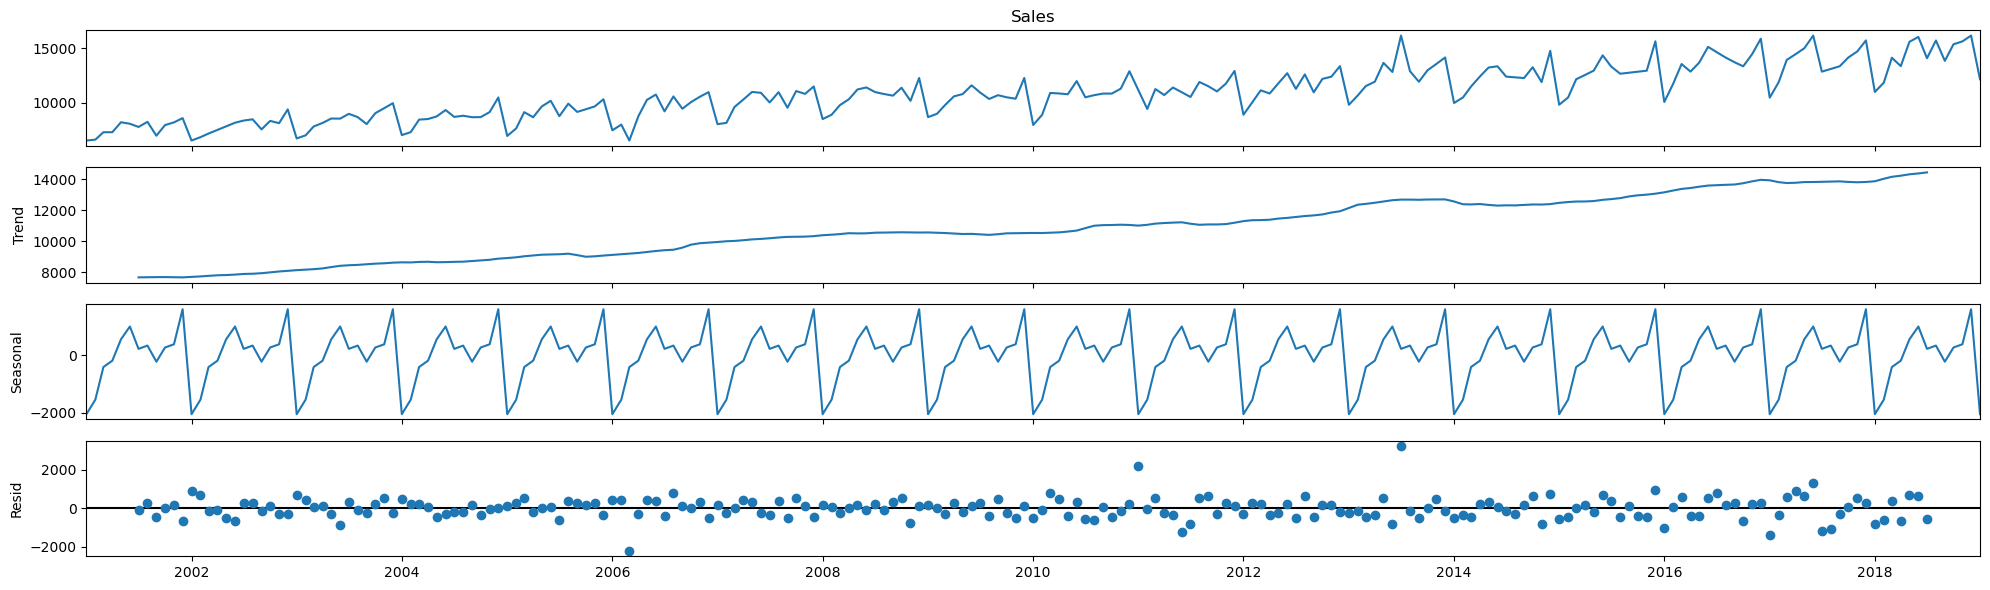

In [26]:
model.plot()

Here's how the additive decomposition is happening:

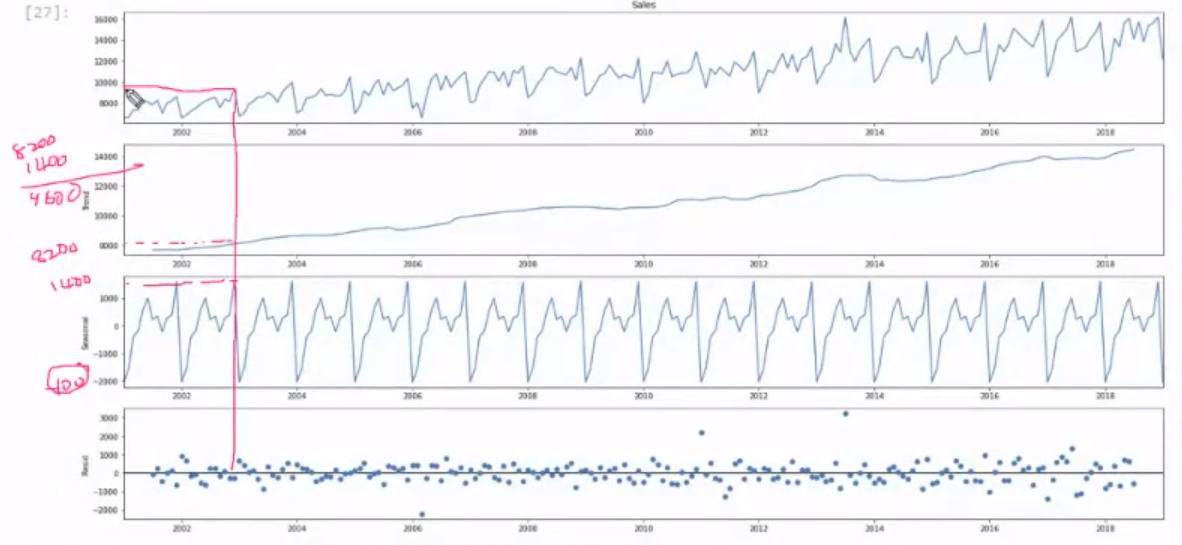

The actual value of time series at the marked point is 10,000<br>
Trend gives us 8200 (approx)<br>
Seasonality gives us 1400 (approx)<br>
error let's say is 100<br>
If we add the three, we get the actual time series. 9500 (This will actually be 10k. It's just that all these values were approx.)<br>
That's the **additive decomposition**.

##### Checking decomposition using the actual values

In [31]:
model.trend[-10:-5]

DATE
2018-04-01    14225.375000
2018-05-01    14313.625000
2018-06-01    14370.186667
2018-07-01    14436.665000
2018-08-01             NaN
Name: trend, dtype: float64

In [32]:
model.seasonal[-10:-5]

DATE
2018-04-01    -185.047675
2018-05-01     559.648403
2018-06-01    1006.155854
2018-07-01     227.369231
2018-08-01     341.476835
Name: seasonal, dtype: float64

**we are calculating avg in seasonality calculation (i.e original -trend ie. y - b), so it is including seasonal and random both. Why?<br>**
If the avg temperature is 30(**trend**). Jan will be slightly below that. Jan is 3 degrees below(**seasonality**) the avg temperature. But, not every Jan will be exactly 3 degrees below. Sometimes, it could be 3 degrees and other time 4 degrees. So, when it is 3 deg, no error, 0. When it is 2 deg, error would be 1. When it is 4 degrees, error would be -1. So, on avg after taking the trend component out, what's the Jan value, we're taking the avg. So, on avg, Jan would be 4 deg lesser than the trend component. But, not every Jan would be like that cuz it's an avg. Sometimes it'll be more/less and that's when the error component comes in. 

In [33]:
model.resid[-10:-5]

DATE
2018-04-01   -680.327325
2018-05-01    702.726597
2018-06-01    644.657479
2018-07-01   -584.034231
2018-08-01           NaN
Name: resid, dtype: float64

In [34]:
mobile_sales.Sales[-10:-5]

DATE
2018-04-01    13360.0
2018-05-01    15576.0
2018-06-01    16021.0
2018-07-01    14080.0
2018-08-01    15697.0
Name: Sales, dtype: float64

In [50]:
14225.375000 - 185.047675 - 680.327325   # trend - seasonal - residual = Sales

13360.0

Actual value for Apr is 13360.0<br>
As per trend, the value should be 14225.375000<br>
But, as per seasonality, in Apr, we will see slightly lesser sales: -185.047675<br>
But, in this particular year, it was way below that: -680.327325 and it isn't explained by seasonality or trend, so that's why it went in the error component.

In [46]:
model.trend   
# these missing values could be due to the fact that trend is calculated using rolling avg which gives NaN if there aren't enough values to calculate.

DATE
2001-01-01   NaN
2001-02-01   NaN
2001-03-01   NaN
2001-04-01   NaN
2001-05-01   NaN
              ..
2018-09-01   NaN
2018-10-01   NaN
2018-11-01   NaN
2018-12-01   NaN
2019-01-01   NaN
Name: trend, Length: 217, dtype: float64

In [47]:
# Fixing missing values in trend by extrapolating
import statsmodels.api as sm

model = sm.tsa.seasonal_decompose(mobile_sales.Sales, model='additive', extrapolate_trend = 5)   # extrapolate also adds the values which were missing.

In [49]:
model.trend

DATE
2001-01-01     7688.716508
2001-02-01     7688.823651
2001-03-01     7688.930794
2001-04-01     7689.037937
2001-05-01     7689.145079
                  ...     
2018-09-01    14701.167063
2018-10-01    14799.621706
2018-11-01    14898.076349
2018-12-01    14996.530992
2019-01-01    15094.985635
Name: trend, Length: 217, dtype: float64

### Multiplicative Decomposition

In [51]:
import statsmodels.api as sm

model = sm.tsa.seasonal_decompose(mobile_sales.Sales, model='multiplicative')   # tsa = time series analysis

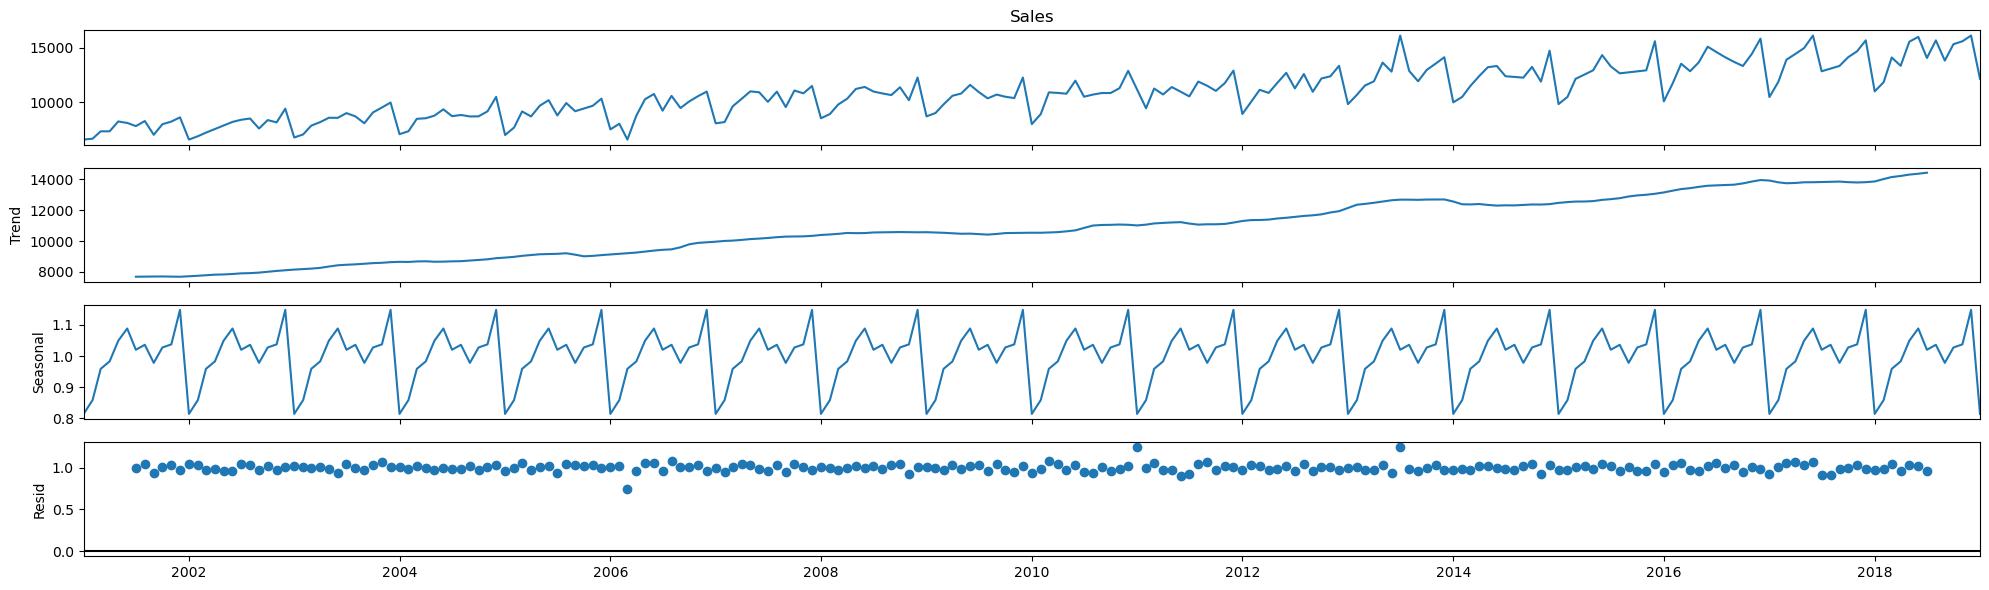

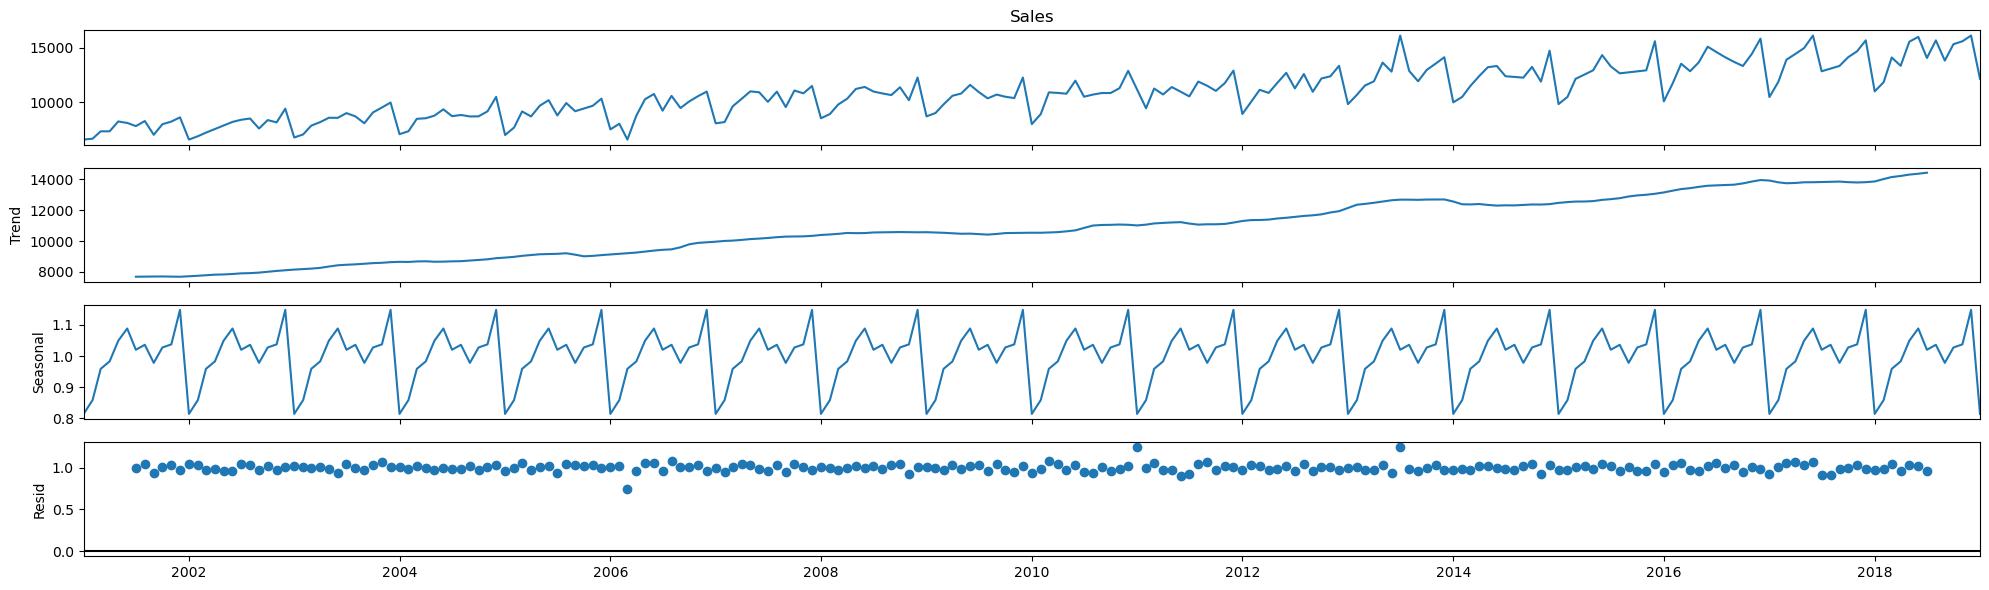

In [52]:
model.plot()

Our Time Series has more or less constant fluctuations. Hence, using additive decomposition makes sense.

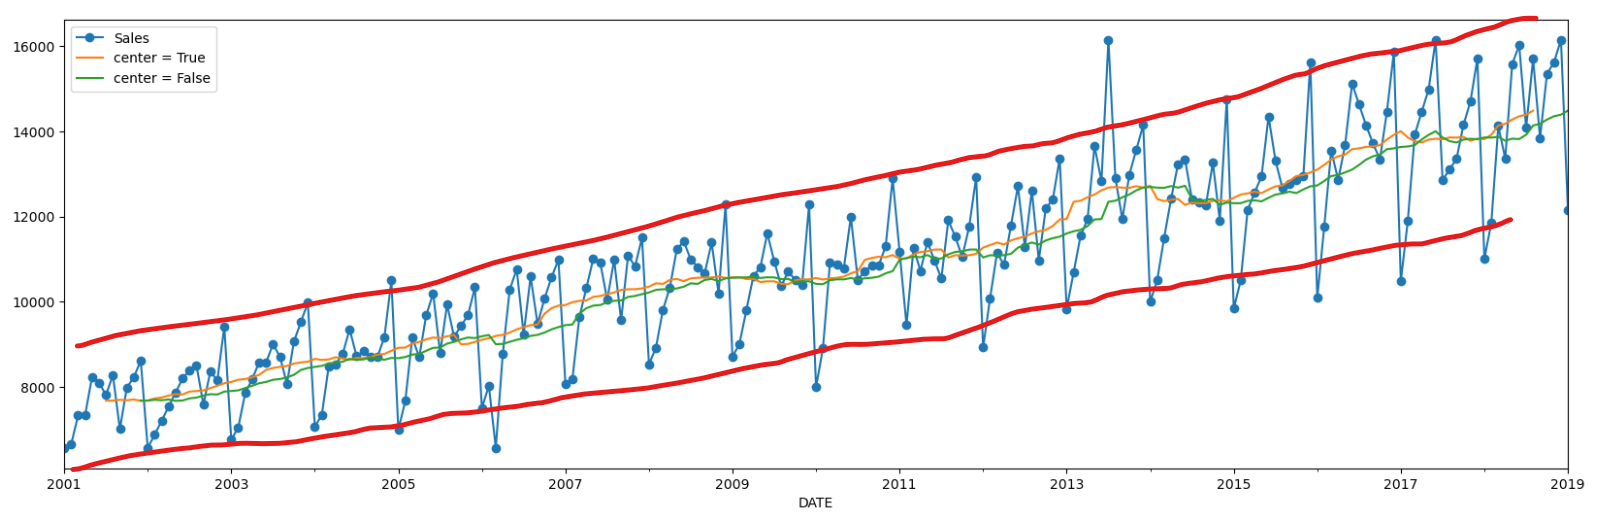

If there were too many fluctuations and non-constant variance, we would have gone with multiplicative decomposition.

Residuals in case of Additive decomposition will be centered around 0. 

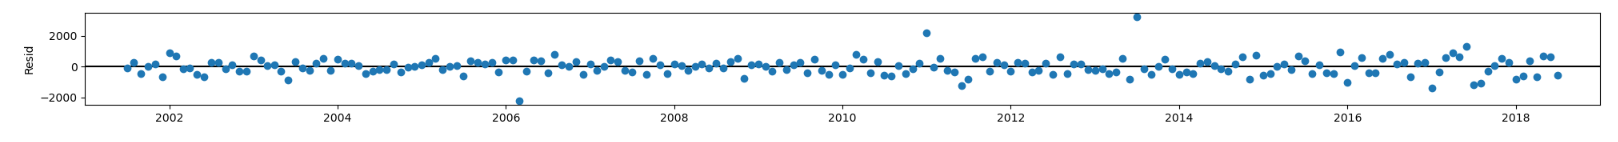

Residuals in case of Multiplicative decomposition will be centered around 1 because it's a ratio of leftover trend vs. seasonal component.

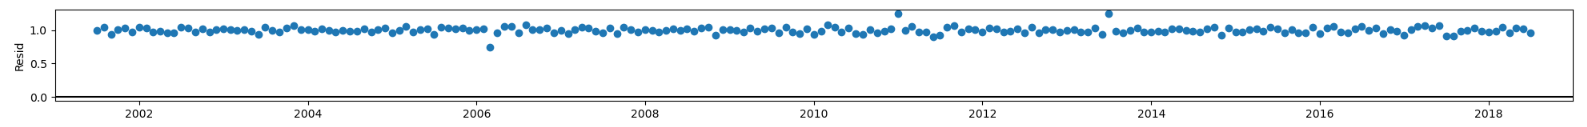

**If you have any questions, get in touch with me here:**<br><br>
[Stalk and Support Me](https://linktr.ee/khushalkumar31)